In [ ]:
# Getting started

In [2]:
push!(LOAD_PATH, "../../../ExoJulia/")

3-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                

In [ ]:
Pkg.add("LsqFit")

In [3]:
using ExoJulia
using PyPlot
using LsqFit

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [373]:
include("utils.jl")
include("orbital_utils.jl")
include("rv.jl")

agol_periodogram (generic function with 1 method)

### Read-in Mystery RV data

In [111]:
numbers = readdlm("mystery_planet.txt");

In [21]:
time = numbers[:,1];
rv = numbers[:,2];
err = numbers[:,end];

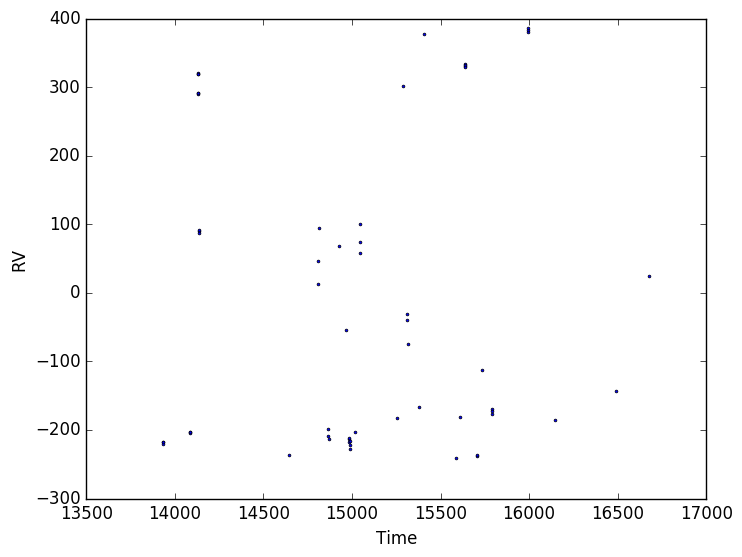

PyObject <matplotlib.text.Text object at 0x320b2ee90>

In [25]:
plot(time, rv, "o", ms=2.0)
xlabel("Time")
ylabel("RV")

## Period Fitting

### Agol Method

In [32]:
periods = linspace(1.0, 365.0, 1000)

linspace(1.0,365.0,1000)

In [33]:
p = collect(periods);

In [95]:
@time best_period = agol_periodogram(numbers, p)

116.50350350350351

0.009507 seconds (30.01 k allocations: 8.708 MB)


## RV Fitting

In [144]:
time_fold = numbers[:,1]; 
RV_fold = numbers[:,2];
err_fold = numbers[:,3];

In [203]:
function func1(x, p::Vector)
    # p = [h,c,v0]
    p[1].*cos(x) .+ p[2].*sin(x) .+ p[3]
end

func1 (generic function with 2 methods)

In [287]:
function func2(x, p::Vector)
    # p = [K, w, ecc, gamma]
    #x ==  time, but we want dat f
    f = zeros(length(x))
    for i=1:length(x)
        M = mean_anomaly(best_period, x[i], 0.0)
        f[i] = f_from_M!(p[3], M)
    end 
    p[1] .* (cos(p[2] .+ f) .+ p[3] .* cos(p[2])) .+ p[4]
end

func2 (generic function with 2 methods)

In [288]:
@time fit2 = curve_fit(func2, time_fold, RV_fold, 1.0./err_fold.^2, [400.0, 0.0, 0.1, -1000.]);

  0.046463 seconds (149.63 k allocations: 7.949 MB, 9.65% gc time)


In [305]:
@time fit1 = curve_fit(func1, time_fold, RV_fold, 1.0./err_fold.^2, [100.0, 0.0, 0.0]);

  0.085335 seconds (4.47 k allocations: 520.608 KB)


In [149]:
fit1.param

3-element Array{Float64,1}:
  -62.2453
 -111.192 
  -29.0617

In [289]:
fit_params = fit2.param

4-element Array{Float64,1}:
 289.144   
   0.949377
  -0.584578
  66.4796  

In [297]:
estimate_errors(fit1)

3-element Array{Float64,1}:
 62.5504
 71.3523
 47.594 

In [138]:
estimate_covar(fit2)

4x4 Array{Float64,2}:
 1850.73       -0.793031     1.8264e10   -1.5507e12 
   -0.793031    0.237385     1.66066e8   -1.40998e10
    1.8264e10   1.66066e8    1.38058e19  -1.17218e21
   -1.5507e12  -1.40998e10  -1.17218e21   9.95231e22

In [112]:
numbers[:,1] = mod(numbers[:,1] - numbers[1,1], best_period);

In [113]:
fastsortrows(numbers, [1]);

In [114]:
numbers

59x3 Array{Float64,2}:
   0.0      -217.7  1.0
   0.00068  -221.0  1.0
   0.0014   -217.8  1.0
  34.8409   -203.3  1.3
  34.8416   -204.2  1.3
  34.8423   -203.6  1.2
  79.797     321.0  1.1
  79.7976    318.4  1.1
  79.7983    319.2  1.1
  80.7911    290.6  1.2
  80.7918    291.0  1.2
  80.7925    291.7  1.1
  88.7764     90.7  1.2
   ⋮                   
  25.3589   -238.4  1.0
  26.3561   -237.0  1.2
  50.566    -113.1  1.3
 111.346    -177.0  1.3
 111.346    -170.0  1.3
 111.347    -172.8  1.2
  78.6431    379.9  1.3
  78.6455    382.7  1.4
  78.6487    386.1  1.5
 114.841    -185.9  1.2
 108.339    -142.7  1.1
  61.7846     24.3  1.4

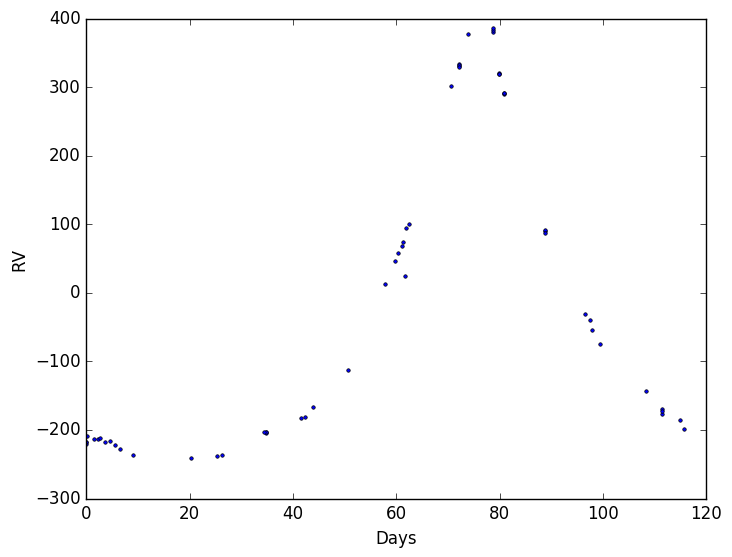

PyObject <matplotlib.text.Text object at 0x32c645c90>

In [141]:
plot(numbers[:,1], numbers[:,2], "o", ms=2.5)
xlabel("Days")
ylabel("RV")

In [292]:
K = fit_params[1];
w = fit_params[2];
ecc = fit_params[3]; 
gamma = fit_params[4];

In [293]:
vrad_fit = zeros(length(time))
for i=1:length(time)
    M = mean_anaomoly!(best_period, time[i], time[1])
    f = f_from_M!(ecc, M)
    vrad_fit[i] = v_rad!(K, w, f, ecc, gamma)
    
end

In [285]:
function fit_to_physical(h::Float64,c::Float64,v0::Float64)
    w = atan(-c/h)
    K = h / cos(w)
    
end

fit_to_physical (generic function with 1 method)

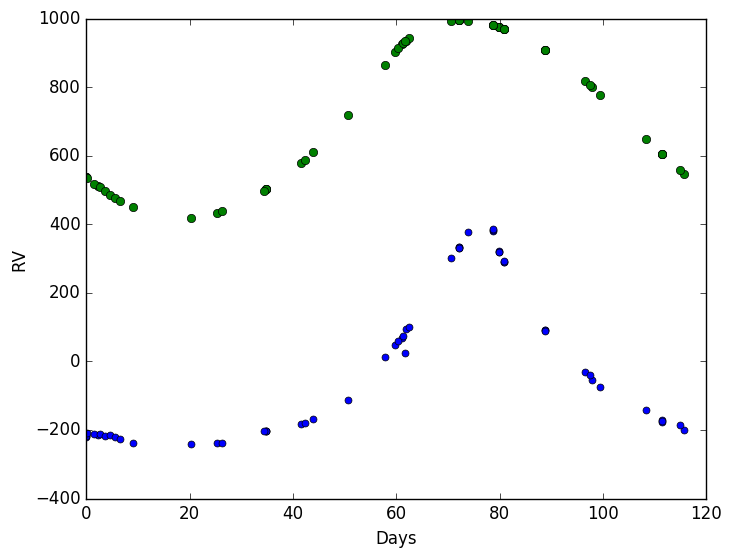

PyObject <matplotlib.text.Text object at 0x330e1a210>

In [294]:
plot(numbers[:,1], numbers[:,2], "o", ms=5)
plot(time_fold, vrad_fit, "o")
xlabel("Days")
ylabel("RV")

In [290]:
using Optim

In [307]:
function lnlike(x, p::Vector)
    mod = func2(x, p)
    ll = 0.0
    for i=1:length(rv)
        ll -= 0.5 .* (mod .- rv)^2 ./ err.^2
    end 
end 

lnlike (generic function with 1 method)

In [308]:
optimize(lnlike, [400.0, 0.0, 0.1, -1000.], autodiff=true)

LoadError: LoadError: MethodError: `lnlike` has no method matching lnlike(::Array{Float64,1})
Closest candidates are:
  lnlike(::Any, !Matched::Array{T,1})
while loading In[308], in expression starting on line 1

### Trying an MCMC

In [301]:
Pkg.add("Lora")

INFO: Cloning cache of DataStructures from git://github.com/JuliaLang/DataStructures.jl.git
INFO: Cloning cache of Formatting from git://github.com/lindahua/Formatting.jl.git
INFO: Cloning cache of ForwardDiff from git://github.com/JuliaDiff/ForwardDiff.jl.git
INFO: Cloning cache of Graphs from git://github.com/JuliaLang/Graphs.jl.git
INFO: Cloning cache of Lora from git://github.com/JuliaStats/Lora.jl.git
INFO: Cloning cache of ReverseDiffSource from git://github.com/JuliaDiff/ReverseDiffSource.jl.git
INFO: Installing DataStructures v0.4.3
INFO: Installing Formatting v0.1.5
INFO: Installing ForwardDiff v0.1.6
INFO: Installing Graphs v0.6.0
INFO: Installing Lora v0.5.2
INFO: Installing ReverseDiffSource v0.2.2
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Lora
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [302]:
using Lora

INFO: Precompiling module DataStructures...
INFO: Precompiling module ForwardDiff...


### Matrix Approach

In [361]:
function WH_W(err::Array{Float64,1})
    # Compose Wright & Howard W matrix
    W = zeros(Float64,length(err), length(err))
    for i=1:length(err)
        W[i,i] = 1./err[i]^2
    end 
    return W
end 

WH_W (generic function with 1 method)

In [358]:
@time W = WH_W(err);

  0.006121 seconds (2.75 k allocations: 163.008 KB)


In [343]:
function f_from_t(P::Float64, ecc::Float64, t::Float64, tp::Float64)
    f_from_M(ecc, mean_anomaly(P, t, tp))
end 

f_from_t (generic function with 1 method)

In [360]:
function WH_F(P::Float64, ecc::Float64, t::Array{Float64, 1}, tp::Float64; Nplanets::Int=1)
    # Compute Wright & Howard F matrix
    
    # Allocate matrix
    F = zeros(Float64, (2*Nplanets+2), length(t))
    
    # Fill matrix
    for i=1:Nplanets
        for j=1:length(t)
            f = f_from_t(P, ecc, t[j], tp)
            F[2*i - 1,j] = cos(f)
            F[2*i, j] = sin(f)
        end 
    end 
    
    # 
    for j=1:length(t)
        F[end-1, j] = 1.0
        F[end, j] = t[j] - t[1]
    end 
    return F
end

WH_F (generic function with 2 methods)

In [348]:
F = WH_F(best_period, 0.1, time, 1.0)

4x59 Array{Float64,2}:
  0.96572    0.965716   0.965711   -0.210093  …     0.998194     -0.0971979
 -0.259586  -0.259603  -0.25962    -0.977681       -0.0600714     0.995265 
  1.0        1.0        1.0         1.0             1.0           1.0      
  0.0        0.00068    0.0014    151.344        2554.91       2741.37     

In [354]:
function WH_eps(F::Array{Float64, 2}, W::Array{Float64, 2})
    # Compute Wright & Howard epsilon matrix
    return inv(F * W * (F'))
end 

WH_eps (generic function with 1 method)

In [359]:
WH_eps(F, W)

4x4 Array{Float64,2}:
  0.0857657     0.000335324  -0.0542203    8.1863e-6 
  0.000335324   0.0628552    -0.00516512  -2.22184e-6
 -0.0542203    -0.00516512    0.115636    -5.73326e-5
  8.1863e-6    -2.22184e-6   -5.73326e-5   5.01336e-8

In [371]:
function WH_Beta(RV::Array{Float64, 2}, F::Array{Float64, 2}, W::Array{Float64, 2})
    # Compute Wright & Howard Beta vector
    return RV * W * (F') * WH_eps(F, W)
end 

WH_Beta (generic function with 2 methods)

In [370]:
B = WH_Beta(rv', F, W)

1x4 Array{Float64,2}:
 9.83097  297.156  -31.8704  -0.0164657

In [382]:
function rv_forward(P::Float64, ecc::Float64, tp::Float64, t::Array{Float64,1}, rv::Array{Float64,1}, err::Array{Float64,1}; Nplanets::Int=1)
    # Calculates model RV given linear params: [h, c, v0, d, tp]
    
    # Allocate 
    rv_mod = zeros(Float64, Nplanets, length(t))
    
    # Calculate Wright & Howard Beta Vector, B = [h_i, c_i, ..., h_n, c_n, v0, d] for n planets
    B = WH_Beta(rv', WH_F(P, ecc, t, tp), WH_W(err))
    
    # Loop over planets and observations, calculating model rv points
    for i=1:Nplanets
        for j=1:length(t)
            f = f_from_t(P, ecc, t[j], tp)
            rv_mod[i,j] = v_rad_lin(B[i,1], f, B[i,2], B[i,end-1], t[j], t[1], B[i,end])
        end 
    end 
    
    return rv_mod, B
end 

rv_forward (generic function with 1 method)

In [380]:
function loglike(data, model, err)
    # Chi^2
    ll = 0.0;
    for i=1:length(data)
        ll -= 0.5 * (data[i] - model[i])^2 / (err[i])^2;
    end
    return ll
end 

loglike (generic function with 1 method)

In [397]:
ecc = linspace(0.0, 0.99, 1000);
tp = linspace(time[1], time[end], 1000);
period = best_period;

ll_min = -1.0e20;
B_best = nothing;
ecc_best = nothing;
tp_best = nothing;
rv_best = nothing;
for i=1:length(eccentricity)
    for j=1:length(tp)
        rv_mod, B = rv_forward(period, ecc[i], tp[j], time, rv, err);
        ll = loglike(rv, rv_mod, err);
        if ll > ll_min
            B_best = B;
            ll_min = ll;
            ecc_best = ecc[i];
            tp_best = tp[j];
            rv_best = rv_mod;
        end 
    end 
end         

In [398]:
ecc_best

0.0981081081081081

In [399]:
tp_best

14125.909607447446

In [400]:
ll_min

-4080.5133795929896

In [401]:
B_best

1x4 Array{Float64,2}:
 -298.998  9.82652  48.6263  0.00940732

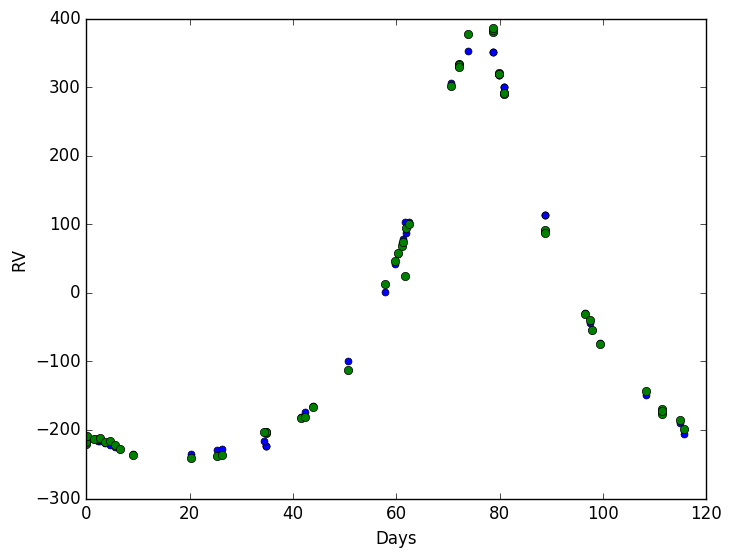

PyObject <matplotlib.text.Text object at 0x332cfa950>

In [402]:
plot(time_fold, rv_best', "o", ms=5)
plot(time_fold, rv, "o")
xlabel("Days")
ylabel("RV")

In [394]:
rv_best'

59x1 Array{Float64,2}:
 -212.315 
 -212.318 
 -212.32  
 -219.742 
 -219.74  
 -219.738 
  320.679 
  320.667 
  320.655 
  300.805 
  300.79  
  300.774 
   99.9778
    ⋮     
 -225.809 
 -224.673 
 -107.519 
 -175.134 
 -175.137 
 -175.14  
  354.405 
  354.372 
  354.325 
 -188.433 
 -152.146 
   92.0869